### Import lib

In [43]:
import sys
sys.path.append('..')

In [44]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

import config
from models.coordinate import Coordinate

### Read data

In [45]:
NUMBER_FACTOR = len(config.DATA_PATH)    # số lượng task - factor  = số file dầu vào

def read_data(data_path):
    cities_list = [None]

    with open(data_path, 'r') as f:
        data = f.readlines()
        number_cities = int(data[3].split(':')[-1].strip())

        for line in data[6: 6 + number_cities]:
            _, x, y = list(map(int, line.split()))
            cities_list.append(Coordinate(x, y))

    return cities_list, number_cities
  

def init_data():
    cities_list = [None]      # list city ứng với mỗi task 
    number_cities = [None] 
    for path in config.DATA_PATH:    
        factorial_cities_list, factorial_number_cities = read_data(path)
        cities_list.append(factorial_cities_list)
        number_cities.append(factorial_number_cities)
    return cities_list,number_cities


# list city     ứng với mỗi task tish từ 1
# số lượng city ứng với mỗi task tính từ 1
CITIES_LIST, NUMBER_CITIES  = init_data()


### Initialize Population

In [46]:
def init_population():
    factor_index = np.argmax([0] + NUMBER_CITIES[1:])
    population = [None] 

    for _ in range(1, config.POPULATION_SIZE + 1 ):  # cái range này chạy từ [) vl. không nói gì thì chạy từ 0
        while True:
            individual = random.sample(
                range(1, NUMBER_CITIES[factor_index] + 1), NUMBER_CITIES[factor_index])

            assert len(set(individual)) == NUMBER_CITIES[factor_index]
            if individual not in population:
                population.append(individual)
                break
        
    return population

population = init_population()     # khởi tạo quần thể bằng max số city 2 task


In [47]:
len(population)

7

In [48]:
def decoded(individual, factor_index):
    return [element for element in individual if element <= NUMBER_CITIES[factor_index]]    # decode  lấy ra thứ tự vừa đủ cho task nhỏ 

# ví dụ 
# task lớn = indiviual = 1 5 2 9 4 8 6 3 7  -> task nhỏ 1 5 2 4 3 (bỏ 9,8,6)

### Adaptive function

In [49]:
def euclidean_distance(index_city1, index_city2, factor_index):
    tmp_CITIES_LIST = CITIES_LIST[factor_index]

    return np.linalg.norm((tmp_CITIES_LIST[index_city1].x - tmp_CITIES_LIST[index_city2].x,
                           tmp_CITIES_LIST[index_city1].y - tmp_CITIES_LIST[index_city2].y))


DISTANCE_MATRIX = [None]

for factor_index in range(1, NUMBER_FACTOR + 1):
    tmp_LENGTH_MATRIX = NUMBER_CITIES[factor_index] + 1
    tmp_DISTANCE_MATRIX = np.zeros((tmp_LENGTH_MATRIX, tmp_LENGTH_MATRIX))

    for i in range(1, NUMBER_CITIES[factor_index] + 1):
        for j in range(1, NUMBER_CITIES[factor_index] + 1):
            if i < j:
                tmp_DISTANCE_MATRIX[i][j] = euclidean_distance(
                    i, j, factor_index)
            elif i > j:
                tmp_DISTANCE_MATRIX[i][j] = tmp_DISTANCE_MATRIX[j][i]
            else:
                tmp_DISTANCE_MATRIX[i][j] = 0

    DISTANCE_MATRIX.append(tmp_DISTANCE_MATRIX)

# trả về ma trận khoảng cách cả 2 task vụ  tí tính cho nhanh 

In [50]:
def cost(individual, factor_index):
    c = 0
    for i in range(len(individual)):   # for hết tính tổng khoảng cách
        c += DISTANCE_MATRIX[factor_index][individual[i]][individual[i+1] if i != len(individual) - 1
                                            else individual[0]]      # thành phố cuối thì quay về đầu 

    return c

# hàm chi phí : trả về chi phí individual ở task factor_index

### Ranking

In [51]:
def get_ranks_of_pop(population):   # phục vụ cho việc tính skill và scalar

    ranks = [None]

    for factor_index in range(1, NUMBER_FACTOR + 1):
        #                 lấy ra lịch trình với task tương ứng r tính cost     # với tất cả các cá thể trong quần thể (index từ 1:) 
        list_cost = [cost(decoded(individual, factor_index), factor_index) for individual in population[1:]]
        ranks.append([None] + [it + 1 for it in np.argsort(list_cost)])
    
    return ranks

# hi vọng Duy code đúng thì cái ranks này là mảng 2 chiều. ví dụ ranks[1] là sort list cost của các cá thể trong task 1 

### Skill-factor & Scalar-fitness

In [52]:
def update_skill_and_scalar(population):

    ranks = get_ranks_of_pop(population)

    skill_factor = [None]     # task mà nó tốt nhất ví dụ skill_factor[cá thể 5] = task vụ 2 
    scalar_fitness = [None]   # 1/ thôi 

    for individual_index in range(1, config.POPULATION_SIZE + 1): 
        tmp_rank = [None]
        for rank in ranks[1:]:
            tmp_rank.append(rank[individual_index])

        skill_factor.append(np.argmin(tmp_rank[1:]) + 1)
        scalar_fitness.append(1/min(tmp_rank[1:]))

    return skill_factor, scalar_fitness

### Select parents

In [53]:
def select_parents(population):
    skill_factor, scalar_fitness = update_skill_and_scalar(population)

    candidate_indexs = random.sample(range(1, config.POPULATION_SIZE + 1), 4)
    winner_indexs = []
    winner_indexs.append(candidate_indexs[0] if scalar_fitness[candidate_indexs[0]] < scalar_fitness[candidate_indexs[1]] else candidate_indexs[1])
    winner_indexs.append(candidate_indexs[2] if scalar_fitness[candidate_indexs[2]] < scalar_fitness[candidate_indexs[3]] else candidate_indexs[3])
    return ((population[winner_indexs[0]], population[winner_indexs[1]]), (skill_factor[winner_indexs[0]], skill_factor[winner_indexs[1]]))


def select_cut_points(parent):
    pos1, pos2 = tuple(random.sample(range(len(parent)), 2))

    return (pos1, pos2) if pos1 > pos2 else (pos2, pos1)


### Crossover

In [54]:
def exec_cross(parent1, parent2, pos1, pos2):
    child = parent1[pos1: pos2 + 1]
    
    tmp = []
    for i in range(pos2 + 1, pos2 + 1 + len(parent2)):
        if i >= len(parent2):
            i %= len(parent2)
        if parent2[i] not in child:
            tmp.append(parent2[i])

    return (tmp[-pos1:] if pos1 != 0 else []) + child + tmp[:len(tmp) - pos1]


def crossover(parents, parent_skill_factors):
    pos1, pos2 = select_cut_points(parents[0])

    children = []
    children.append(exec_cross(parents[0], parents[1], pos1, pos2))
    children.append(exec_cross(parents[1], parents[0], pos1, pos2))
    return (tuple(children), tuple(parent_skill_factors))


def circle_crossover(parents):
    pass
    

### Mutation

In [55]:
def mutation(parents, parent_skill_factors):    # đột biến thì cũng phải gán lại skill factor cho con 
    
    children = []
    children_skill_factors = []

    for parent, parent_skill_factor in zip(parents, parent_skill_factors):
        pos1, pos2 = select_cut_points(parent)

        parent[pos1], parent[pos2] = parent[pos2], parent[pos1]
        children.append(parent)
        children_skill_factors.append(parent_skill_factor)

    return (tuple(children), tuple(children_skill_factors))



### Generate offspring

In [72]:
def gen_offspring(population):
    offspring = [None]     # thế hệ con sinh dần -> tiến tới POPULATION_SIZE
    offspring_skill_factor = [None]

    while len(offspring) < len(population)  : # len chạy từ 1 -> 
        parents, parent_skill_factors = select_parents(population)
        
        if parent_skill_factors[0] == parent_skill_factors[1] or random.random() < config.RMP: 
                # nếu có thực hiện lai ghép 
            children_cross, children_cross_skill_factors = crossover(parents, parent_skill_factors)
            if children_cross != None:   
                for child, child_skill_factor in zip(children_cross, children_cross_skill_factors):
                    offspring.append(child)
                    offspring_skill_factor.append(child_skill_factor)
        else:   # nếu có thực hiện đột biến 
            children_mut, children_mut_skill_factors = mutation(parents, parent_skill_factors)
            if children_mut != None:      
                for child, child_skill_factor in zip(children_mut, children_mut_skill_factors):
                    offspring.append(child)                              # append nó vào vị trí 1 chẳng hạn 
                    offspring_skill_factor.append(child_skill_factor)    # thì cũng append tên task nó tốt nhất (ví dụ task 1) vào vị trí 1 đó 
                
    assert len(offspring) >= len(population)


    # tiến hành hợp quần thể cũ và quần thể mới 
    for individual in population : 
        if individual != None:
            offspring.append(individual)
    
    # thực ra cái offspring_skill_factor chho vui chứ tí vẫn tính lại 
    # skill_factor, _ = update_skill_and_scalar(population)
    # for individual_skill in skill_factor:
    #     offspring_skill_factor.append(individual_skill)

    # giữ lại top POPULATION_SIZE tốt nhất theo scalar_fit 
    skill_factor , scalar_fitness = update_skill_and_scalar(offspring)
    index_top_fit = sorted(range(1,len(scalar_fitness)), key=lambda i: scalar_fitness[i])[-config.POPULATION_SIZE:]

    offspring_top_fit = [None]
    for index in index_top_fit:
        offspring_top_fit.append(offspring[index])

    skill_factor , scalar_fitness = update_skill_and_scalar(offspring_top_fit)
    his = cost(offspring_top_fit[2],skill_factor[2])

    return offspring_top_fit,his


In [73]:
history = [None] 

for i in tqdm(range(config.NUM_GENERATIONS)):
    
    offspring, best_cost = gen_offspring(population)
    history.append(best_cost)
    population = offspring

  0%|          | 0/10 [00:00<?, ?it/s]


IndexError: index 11 is out of bounds for axis 0 with size 11

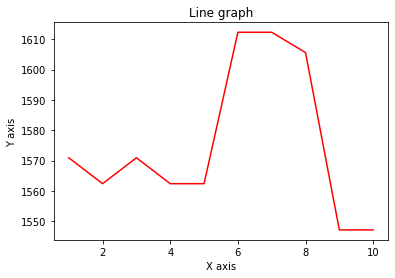

In [63]:
plt.title("Line graph")
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.plot(range(1, len(history)), list(map(lambda x: x, history[1:])), color ="red")
plt.show()